# Exploring ASAP dataset

Dataset of [Aligned Scores and Performances](https://github.com/fosfrancesco/asap-dataset/tree/master)

In [3]:
import sys
sys.path.append("..")

from src.data import extract_piano_roll, calculate_cross_similarity, construct_beat_alignment
from src.utils import plot_piano_roll, plot_cross_similarity, seconds_to_frames

import os
import json

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Path to the clonned ASAP repository

asap_dir = "../../asap-dataset"

In [5]:
annotations_path = os.path.join(asap_dir, 'asap_annotations.json')

In [6]:
with open(annotations_path, "r", encoding="utf8") as f:
    annotations = json.load(f)

In [7]:
print(f"Number of pieces in ASAP: {len(annotations)}")

Number of pieces in ASAP: 1067


Let's take a look at one of the performances of Schubert's Impromptu Op. 90 No. 2

In [8]:
piece_title = 'Schubert/Impromptu_op.90_D.899/2'
performer = 'Denisova11M.mid'
perf_title = os.path.join(piece_title, performer)
perf_path = os.path.join(asap_dir, perf_title)

score_path = os.path.join(asap_dir, piece_title, 'midi_score.mid')

In [9]:
list(annotations[perf_title].keys())

['performance_beats',
 'performance_downbeats',
 'performance_beats_type',
 'perf_time_signatures',
 'perf_key_signatures',
 'midi_score_beats',
 'midi_score_downbeats',
 'midi_score_beats_type',
 'midi_score_time_signatures',
 'midi_score_key_signatures',
 'downbeats_score_map',
 'score_and_performance_aligned']

In [10]:
perf_beats = np.array(annotations[perf_title]['performance_beats'])

print("Number of annotated beats in performance:", len(perf_beats))

Number of annotated beats in performance: 848


In [11]:
score_beats = np.array(annotations[perf_title]['midi_score_beats'])

print("Number of annotated beats in the score:", len(score_beats))

Number of annotated beats in the score: 848


As we can see, the number of annotated beats match.

# Cross-similarity

In [12]:
# Sampling frequency for piano rolls
fs = 40

In [13]:
perf_roll = extract_piano_roll(perf_path, fs=fs)
perf_roll.shape

torch.Size([8934, 128])

/home/dmgvrlv/code/dcnn-alignment/notebooks/../src/utils.py:19: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll.T.numpy()[start_pitch:end_pitch + 1],


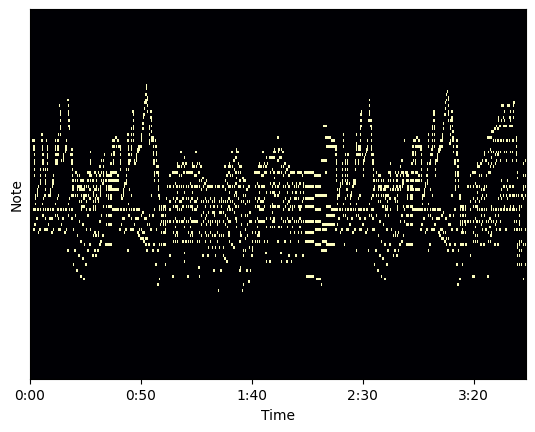

In [14]:
plot_piano_roll(perf_roll, fs)

In [15]:
score_roll = extract_piano_roll(score_path)
score_roll.shape

/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


torch.Size([16959, 128])

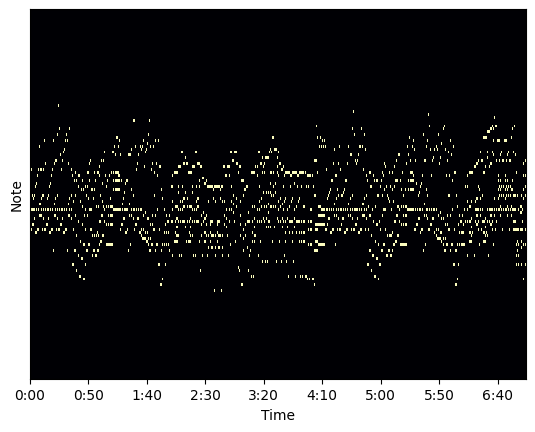

In [16]:
plot_piano_roll(score_roll, fs)

In [17]:
cross_similarity = calculate_cross_similarity(perf_roll, score_roll)
cross_similarity.shape

torch.Size([8934, 16959])

In [18]:
beat_alignment = construct_beat_alignment(perf_beats, score_beats, fs)
beat_alignment.shape

(2, 848)

In [19]:
beat_alignment

array([[   44,    60,    70, ...,  8899,  8910,  8920],
       [    0,    20,    40, ..., 16900, 16920, 16940]])

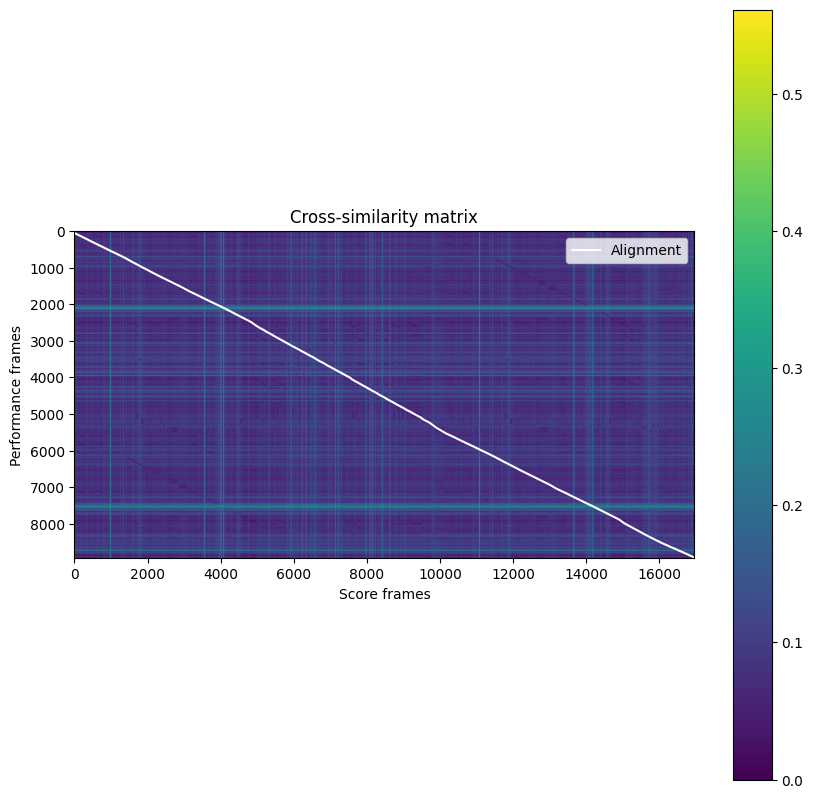

In [20]:
plot_cross_similarity(cross_similarity, beat_alignment=beat_alignment)

In [21]:
cross_similarity

tensor([[0.0353, 0.0353, 0.0353,  ..., 0.0725, 0.0725, 0.0725],
        [0.0353, 0.0353, 0.0353,  ..., 0.0725, 0.0725, 0.0725],
        [0.0353, 0.0353, 0.0353,  ..., 0.0725, 0.0725, 0.0725],
        ...,
        [0.0911, 0.0911, 0.0911,  ..., 0.0180, 0.0180, 0.0180],
        [0.0911, 0.0911, 0.0911,  ..., 0.0180, 0.0180, 0.0180],
        [0.0911, 0.0911, 0.0911,  ..., 0.0180, 0.0180, 0.0180]])

# Augmentations

In [37]:
from typing import List, Tuple
import numpy as np
import torch
from torch import nn


def sample_jumps(beat_alignment: np.ndarray,
                 max_num_jumps: int = 2) -> List[Tuple[int, int]]:
    """Samples segments with jumps.

    Args:
        beat_alignment: Beatwise alignment array in frames of shape (2, num_beats),
          where the first and second rows correspond to performance and score,
          respectively.
        max_num_jumps: The maximum number of jumps.

    Returns:
        A list of pairs of segment timestamps in frames.
    """
    perf_beats = beat_alignment[0]

    timestamps = []

    indices = np.arange(len(perf_beats))
    start_idx = 0
    for _ in range(max_num_jumps):
        end_idx = torch.randint(start_idx, indices[-1], size=(1,)).item()
        timestamps.append((perf_beats[start_idx], perf_beats[end_idx]))
        start_idx = torch.randint(0, end_idx, size=(1,)).item()
    timestamps.append((perf_beats[start_idx], perf_beats[-1]))

    return timestamps

In [38]:
def augment_performance(perf_roll: torch.Tensor,
                        beat_alignment: np.ndarray,
                        segment_timestamps: List[Tuple[int, int]]) -> Tuple[torch.Tensor, np.ndarray]:
    """Augments a performance with jumps.

    Args:
        perf_roll: Performance piano roll tensor of shape (perf_frames, 128).
        beat_alignment: Beatwise alignment array in frames of shape (2, num_beats),
          where the first and second rows correspond to performance and score,
          respectively.
        segment_timestamps: A list of pairs of segment timestamps in frames.

    Returns:
        Augmented performance piano roll with jumps; the new beat alignment;
          and the inflection points of shape (2 * k - 2, 2), where `k` is the
          number of segments.
    """
    ### TODO: add random silence after each segment

    new_perf_roll = torch.zeros((0, 128))
    new_beat_alignment = np.zeros((2, 0)).astype('int')
    perf_beats = beat_alignment[0]

    inflection_points = np.zeros((2 * len(segment_timestamps) - 2, 2))

    offset = 0
    for i, ts in enumerate(segment_timestamps):
        # Construct new piano roll from segments
        start_idx, end_idx = ts
        segment = perf_roll[start_idx:end_idx]
        new_perf_roll = torch.cat((new_perf_roll, segment), dim=0)

        # Retrieve beat indices for alignment
        start_idx =  np.argwhere(perf_beats == start_idx).item()
        end_idx = np.argwhere(perf_beats == end_idx).item()
        # Construct new beat alignment from segment alignments
        segment_alignment = beat_alignment[:, start_idx:end_idx].copy()
        segment_alignment[0] -= segment_alignment[0, 0]
        segment_alignment[0] += offset
        new_beat_alignment = np.concatenate((new_beat_alignment, segment_alignment), axis=1)
        offset = new_beat_alignment[0, -1] + beat_alignment[0, end_idx] - beat_alignment[0, end_idx-1]

        # Add inflection points
        if i > 0:
            inflection_points[i * 2 - 1] = segment_alignment[:, 0]
        if i < len(segment_timestamps) - 1:
            inflection_points[i * 2] = segment_alignment[:, -1]

    return new_perf_roll, new_beat_alignment, inflection_points

In [39]:
segment_timestamps = sample_jumps(beat_alignment, max_num_jumps=3)
segment_timestamps

[(44, 1248), (80, 3815), (936, 8755), (1588, 8920)]

In [40]:
aug_perf_roll, aug_beat_alignment, inflection_points = augment_performance(perf_roll, beat_alignment, segment_timestamps)

In [41]:
print(f'Piano roll shape: {perf_roll.shape}')
print(f'Augmented piano roll shape: {aug_perf_roll.shape}')

Piano roll shape: torch.Size([8934, 128])
Augmented piano roll shape: torch.Size([20090, 128])


In [42]:
print(f'Beat alignment shape: {beat_alignment.shape}')
print(f'Augmented beat alignment shape: {aug_beat_alignment.shape}')

Beat alignment shape: (2, 848)
Augmented beat alignment shape: (2, 1910)


In [43]:
beat_alignment

array([[   44,    60,    70, ...,  8899,  8910,  8920],
       [    0,    20,    40, ..., 16900, 16920, 16940]])

In [44]:
aug_beat_alignment

array([[    0,    16,    26, ..., 20059, 20069, 20080],
       [    0,    20,    40, ..., 16880, 16900, 16920]])

In [45]:
inflection_points

array([[ 1193.,  2340.],
       [ 1204.,    60.],
       [ 4925.,  7160.],
       [ 4939.,  1760.],
       [12748., 16560.],
       [12758.,  3040.]])

In [46]:
aug_cross_similarity = calculate_cross_similarity(aug_perf_roll, score_roll)
aug_cross_similarity.shape

torch.Size([20090, 16959])

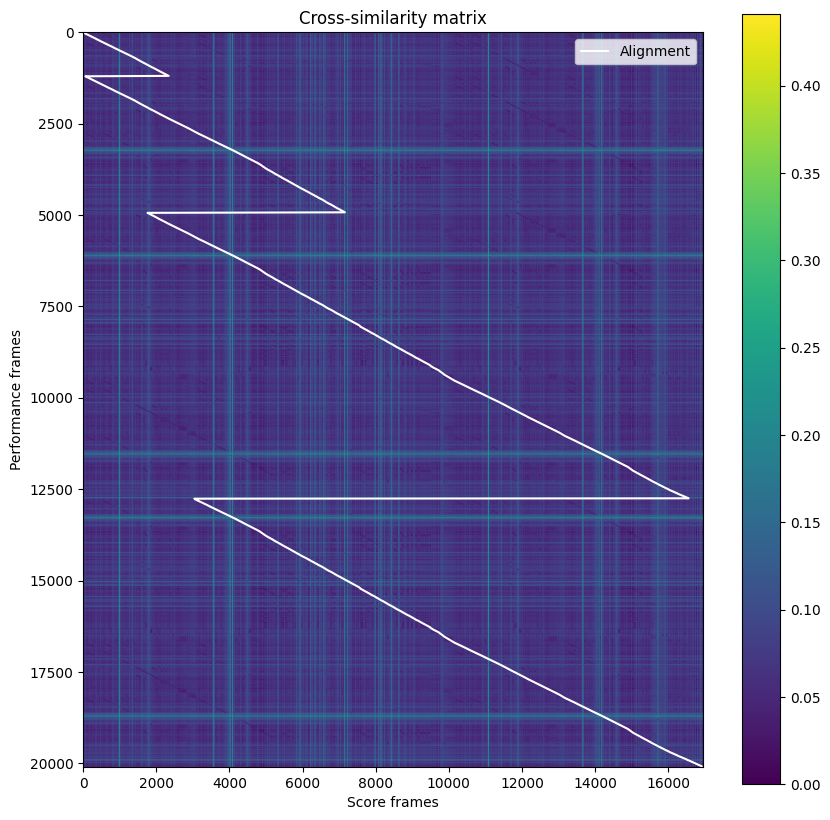

In [47]:
plot_cross_similarity(aug_cross_similarity, beat_alignment=aug_beat_alignment)

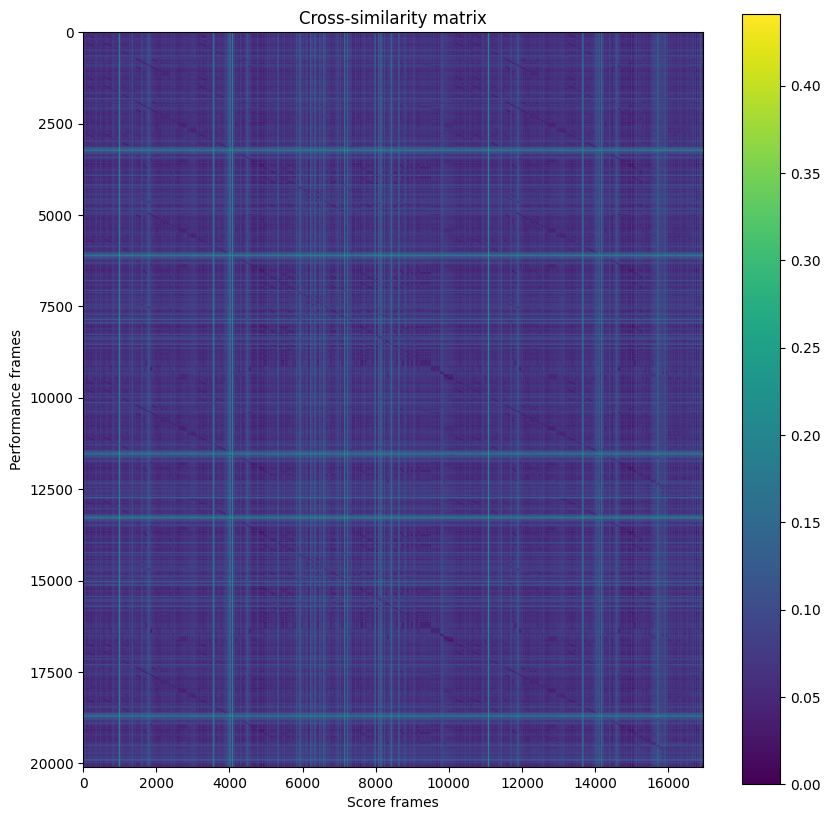

In [48]:
plot_cross_similarity(aug_cross_similarity, beat_alignment=None)